In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math
import pathlib
import re

In [2]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
#     ax.legend()

# Loading Data

In [4]:
results = pd.read_csv("matmul.csv", header=0, comment="#")
resultsWarm = results[ results['warm'] ]
resultsWarm.set_index('name', inplace=True)

resultsCold = results[ ~results['warm'] ]
resultsCold.set_index('name', inplace=True)

resultsWarm

,n_KHit,t_cudaMM,n_hostDMiss,t_hostDLoad,s_hostDLoad,n_devDMiss,t_devDEvict,s_htod,t_htod,n_hostDHit,...,s_devDWriteBack,n_KMiss,t_kernelLoad,warm,t_e2e,mode,nrepeat,matDim,depth,nbyte
name,,,,,,,,,,,,,,,,,,,,,
smallDirect,4.0,3.150928,9.0,0.033643,4194432.0,9.0,0.012158,2.097165e+07,0.904541,7.0,...,0.0,0.0,0.0,True,82.989453,direct,5,1024,4,37748736
largeDirect,4.0,126.978857,9.0,0.043945,268435584.0,9.0,0.017773,1.342177e+09,81.598828,7.0,...,0.0,0.0,0.0,True,38234.063672,direct,5,8192,4,2415919104
smallRemote,4.0,3.060889,9.0,5.816357,4194432.0,9.0,0.015527,2.097165e+07,1.014355,7.0,...,0.0,0.0,0.0,True,96.535547,process,5,1024,4,37748736
largeRemote,4.0,100.992920,9.0,319.850195,268435584.0,9.0,0.021143,1.342177e+09,81.700879,7.0,...,0.0,0.0,0.0,True,38716.978516,process,5,8192,4,2415919104


# Simple Analysis / Sanity Checking

In [5]:
timeCols = [ name for name in resultsWarm.columns if 't_' in name ]
overheadCols = [ c for c in timeCols if c != 't_e2e' and c != 't_kernel' ]
print(resultsWarm.loc['largeRemote', timeCols])

t_cudaMM              100.993
t_hostDLoad            319.85
t_devDEvict         0.0211426
t_htod                81.7009
t_zero               0.104883
t_kernel                37900
t_dtoh                80.7793
t_hostDWriteBack      202.428
t_kernelLoad                0
t_e2e                   38717
Name: largeRemote, dtype: object


In [6]:
resultsWarm['nbyte'] / (1024*1024)

name
smallDirect      36.0
largeDirect    2304.0
smallRemote      36.0
largeRemote    2304.0
Name: nbyte, dtype: float64

## Uncounted Time
We have a little bit of excess time that hasn't been counted. For remote execution this definitely includes request/response encoding (particularly expensive with stats turned on). There does seem to be some scale-related missing time though that I haven't identified (~28ms in the large case, ~1.5ms in the small)

In [7]:
print(resultsWarm['t_e2e'] - resultsWarm[ [ c for c in timeCols if c != 't_e2e']].sum(axis='columns'))
print(resultsCold['t_e2e'] - resultsCold[ [ c for c in timeCols if c != 't_e2e']].sum(axis='columns'))

name
smallDirect     1.451074
largeDirect    27.793701
smallRemote     4.305908
largeRemote    31.143701
dtype: float64
name
smallDirect     1.957031
largeDirect    27.940186
smallRemote     3.527100
largeRemote    29.986572
dtype: float64


## Overhead %

Warm

In [8]:
(resultsWarm[overheadCols].sum(axis='columns') / resultsWarm['t_e2e'])*100

name
smallDirect     6.779088
largeDirect     0.758516
smallRemote    16.837426
largeRemote     2.029799
dtype: float64

Cold

In [9]:
(resultsCold[overheadCols].sum(axis='columns') / resultsCold['t_e2e'])*100

name
smallDirect    12.553848
largeDirect     1.425938
smallRemote    39.924921
largeRemote     5.862036
dtype: float64

# Plots

## Time Breakdown

In [129]:
def getLimits(df):
    # Time contribution of the non-kernel parts (for the biggest benchmark)
    extraHeight = df.drop(columns=['Kernel']).transpose().sum().max()
    totalHeight = df.transpose().sum().max()
    
    return ((0, extraHeight*1.25), (totalHeight * .75,totalHeight*1.1))


def plotBreakdown(df, title=''):
    ax = df.plot(kind='bar', stacked=True, legend=None)
    make_hatches(ax, df)
    ax.set_title(title)
    ax.set_ylabel("Time (ms)")
    return ax.get_figure()
    
    
def plotBreakdownBroken(df, limits, title=''):
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, gridspec_kw={"height_ratios" : [0.5, 1]})
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax1.set_title(title)
#     ax1.set_ylabel("Time (ms)")
    
    ax2.set_ylim(limits[0][0], limits[0][1])
    ax1.set_ylim(limits[1][0], limits[1][1])
    
    df.plot(kind='bar', stacked=True, ax=ax1, legend=None)
    df.plot(kind='bar', stacked=True, ax=ax2, legend=None)
    make_hatches(ax1, df)
    make_hatches(ax2, df)
    
    # sets the slash on the break on the axis
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Use this to get a legend that can be cropped into the poster
#     ax1.legend(loc='upper left', bbox_to_anchor=(0,-3), ncol=6)
    ax1.legend(loc='upper left', bbox_to_anchor=(1,1))

    ax1.set_xlabel('')
    ax2.set_xlabel('')
    return fig    
    

def cleanBreakdown(df):
    bdDF = df.copy()
    bdDF['PlotName'] = df['mode']
    bdDF['PlotName'] = bdDF['PlotName'].str.replace("direct", "Shared Mem")
    bdDF['PlotName'] = bdDF['PlotName'].str.replace("process", "Redis")
    
    bdDF.set_index('PlotName', inplace=True)

    bdDF = bdDF.loc[:,timeCols]
    bdDF = bdDF[['t_cudaMM','t_hostDLoad', 't_dtoh', 't_htod', 't_hostDWriteBack','t_kernel']]
    bdDF.rename(inplace = True, columns = {'t_cudaMM' : "CUDA MM",'t_hostDLoad' : "KV Read",
                           't_htod' : 'GPU Write', 't_dtoh' : 'GPU Read',
                           't_hostDWriteBack' : "KV Write", 't_kernel' : "Kernel"})
    
    return bdDF
#     large = bdDF.loc[['largeDirect', 'largeRemote']].rename(index={"largeDirect" : 'Shared Mem', "largeRemote" : "Redis"})
#     small = bdDF.loc[['smallDirect', 'smallRemote']].rename(index={"smallDirect" : 'Shared Mem', "smallRemote" : "Redis"})
#     return (small, large)

smallCold = results[ (results['matDim'] == 1024) & ~results['warm'] ]
smallWarm = results[ (results['matDim'] == 1024) & results['warm'] ]
largeCold = results[ (results['matDim'] == 8192) & ~results['warm'] ]
largeWarm = results[ (results['matDim'] == 8192) & results['warm'] ]

smallColdPlt = cleanBreakdown(smallCold)
smallWarmPlt = cleanBreakdown(smallWarm)
largeColdPlt = cleanBreakdown(largeCold)
largeWarmPlt = cleanBreakdown(largeWarm)

'lmroman8-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


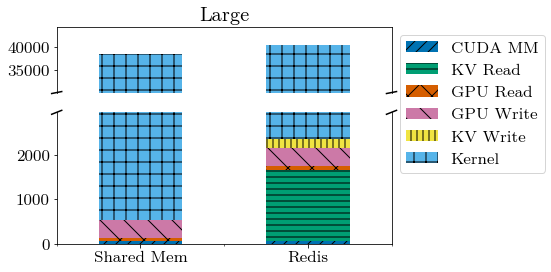

In [131]:
figLargeCold = plotBreakdownBroken(largeColdPlt, getLimits(largeColdPlt), title="Large")
# figLargeWarm = plotBreakdownBroken(largeWarmPlt, getLimits(largeWarmPlt), title="Large")
# figSmallCold = plotBreakdownBroken(smallColdPlt, getLimits(smallColdPlt), title="Small")
# figSmallWarm = plotBreakdownBroken(smallWarmPlt, getLimits(smallWarmPlt), title="Small")

figLargeCold.savefig("mmBreakdownCold.pdf", bbox_inches = "tight", format="pdf")
# figLargeWarm.savefig("mmBreakdownLargeWarm.pdf", bbox_inches = "tight", format="pdf")
# figSmallCold.savefig("mmBreakdownSmallCold.pdf", bbox_inches = "tight", format="pdf")
# figSmallWarm.savefig("mmBreakdownSmallWarm.pdf", bbox_inches = "tight", format="pdf")